In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import datetime
from pathlib import Path
import supy as sp
import os
from shutil import copyfile
import geopandas as gpd
import pickle
pd.options.mode.chained_assignment = None
from IPython.display import clear_output

# Data reading and cleaning

In [2]:
def read_LAI(year):
    df_LAI=pd.read_csv('Crop/IRI/FxMt_IRI-FL_'+str(year)+'_30m_01/FxMt_IRI-FL_'+str(year)+'_not_01.csv')
    df_LAI=df_LAI.drop(0,axis=0)
    df_LAI.index=pd.to_datetime(df_LAI['Unnamed: 0'])
    df_LAI=df_LAI.drop('Unnamed: 0',axis=1)
    df_LAI.columns=['LAI','PLTHT']
    df_LAI=df_LAI.astype(float)
    return df_LAI


def read_LAI_all():
    LAI=pd.read_csv('Crop/IRI/all_data_LAI'+'.csv').set_index('Unnamed: 0')
    LAI.index=pd.to_datetime(LAI.index)
    return LAI

def read_data(year):
    df_all=pd.read_csv('Crop/IRI/all_data_'+str(year)+'.csv')
    df_all=df_all.set_index('datetime')
    df_all.index=pd.to_datetime(df_all.index)
    return df_all


def read_data_all():
    df_all=pd.read_csv('Crop/IRI/all_data'+'.csv')
    df_all=df_all.set_index('datetime')
    df_all.index=pd.to_datetime(df_all.index)
    return df_all


def generate_array_dif(attrs_site, attr,level):
    dar = [0.25,0.25,.25]
    dar[level] = attrs_site[attr].values[0]
    return dar


def generate_array_same(attrs_site, attr):
    a = attrs_site[attr].values[0]
    return [a, a, a]


def modify_attr(df_state_init, df, name):

    all_attrs = pd.read_csv('all_attrs.csv')
    attrs_site = all_attrs[all_attrs.site == name]
    df_state_init.loc[:, 'emissionsmethod'] = 0
    df_state_init.loc[:,'roughlenheatmethod']=1
    

    if attrs_site.land.values[0] == 'DecTr':
        ar = [0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0]
        level = 1
        df_state_init.albmin_dectr=attrs_site['albmin'].values[0]
        df_state_init.albmax_dectr=attrs_site['albmax'].values[0]
        df_state_init.albdectr_id=df_state_init.albmin_dectr
        df_state_init.loc[:, 'dectreeh'] = attrs_site.height.values[0]

    elif attrs_site.land.values[0] == 'EveTr':
        ar = [0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0]
        level = 0
        df_state_init.albmin_evetr=attrs_site['albmin'].values[0]
        df_state_init.albmax_evetr=attrs_site['albmax'].values[0]
        df_state_init.albevetr_id=df_state_init.albmin_evetr
        df_state_init.loc[:, 'evetreeh'] = attrs_site.height.values[0]

    elif attrs_site.land.values[0] == 'Grass':
        ar = [0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0]
        level = 2
        df_state_init.albmin_grass=attrs_site['albmin'].values[0]
        df_state_init.albmax_grass=attrs_site['albmax'].values[0]
        df_state_init.loc[:,'roughlenmommethod']=1
        df_state_init.albgrass_id=df_state_init.albmin_grass
        df_state_init.loc[:,'z0m_in']=attrs_site.height.values[0]*.18
        df_state_init.loc[:,'zdm_in']=attrs_site.height.values[0]*.42

    else:
        print('The land cover type is not found! using the default one')

    df_state_init.loc[:, 'sfr'] = ar
    df_state_init.loc[:, 'lat'] = df.Latitude.values[0].values[0]
    df_state_init.loc[:, 'lng'] = df.Longitude.values[0].values[0]
    df_state_init.loc[:, 'z'] = attrs_site.meas.values[0]
    df_state_init.loc[:, 'laimin'] = generate_array_dif(attrs_site, 'laimin',level)
    df_state_init.loc[:, 'laimax'] = generate_array_dif(attrs_site, 'laimax',level)
    df_state_init.loc[:, 'gddfull'] = generate_array_same(attrs_site, 'gddfull')
    df_state_init.loc[:, 'sddfull'] = generate_array_same(attrs_site, 'sddfull')
    df_state_init.loc[:, 'basete'] = generate_array_same(attrs_site, 'basete')
    df_state_init.loc[:, 'baset'] = generate_array_same(attrs_site, 'baset')
    df_state_init.lai_id = df_state_init.loc[:, 'laimin']
    
    
    

    return df_state_init,level


def func_parse_date(Year, DOY, hours, minutes):
        dt = pd.to_datetime(' '.join(
            [str(k) for k in [Year, DOY, hours, minutes]]),
            format='%Y %j %H %M')
        return dt

In [3]:
def to_SUEWS(year):
    df=pd.read_csv('Crop/IRI/FxMt_IRI-FL_'+str(year)+'_30m_01/FxMt_IRI-FL_'+str(year)+'_30m_01.csv')
    df=df.drop(0,axis=0)

    hours=[]
    minutes=[]
    for x in df.TIME:
        if len(x)==2:
            hour=0
            minute=int(x)
        elif len(x)==3:
            hour=int(x[0])
            minute=int(x[1:])
        elif len(x)==4:
            hour=int(x[0:2])
            minute=int(x[2:])
        if hour==24:
            hour=0
        hours.append(hour)
        minutes.append(minute)

    df['hours']=hours
    df['minutes']=minutes
    df.replace(' ',-99999,inplace=True)
    df=df.astype(float)
    #df=df.replace(-99999,np.nan)
    df['datetime']=df.apply(lambda x: func_parse_date(int(x['Year']),int(x.DOY),int(x.hours),int(x.minutes)),axis=1)
    df=df.set_index('datetime')

    df.replace(-99999,np.nan).to_csv('Crop/IRI/all_data_'+str(year)+'.csv')

    df_period=df

    df_period=df_period.replace(-99999,np.nan).resample('1h').mean().replace(np.nan,-99999)



    input_columns=['iy', 'id', 'it', 'imin', 'qn', 'qh', 'qe', 'qs', 'qf', 'U', 'RH', 'Tair', 'pres', 'rain', 
    'kdown', 'snow', 'ldown', 'fcld', 'Wuh', 'xsmd', 'lai', 'kdiff', 'kdir', 'wdir']
    df_input=pd.DataFrame(columns=input_columns)
    df_input.iy=df_period.index.year
    df_input.id=[x.timetuple().tm_yday for x in df_period.index]
    df_input.it=df_period.index.hour
    df_input.imin=df_period.index.minute
    df_input['kdown']=df_period.Rg.values
    df_input['ldown']=df_period.Rgl.values
    df_input['U']=df_period.WS.values
    df_input['snow']=0
    df_input['rain']=0
    df_input['RH']=df_period.Rh.values
    df_input['Tair']=df_period.Ta.values
    df_input['pres']=101
    df_input['qf']=0
    df_input.qn=df_period.Rn.values


    df_input=df_input.replace(-99999,np.nan)

    for i in ['rain','U','RH','pres']:
        df_input.loc[df_input[df_input[i]<0].index,i]=-999

        df_input.loc[df_input[df_input['Tair']<-50].index,'Tair']=-999
    df_input.fillna(-999,inplace=True)


    name='IRI'
    df_input.to_csv('runs/data/'+name+'_'+str(year)+'_data_60.txt',sep=' ',index=0)
    return df_input

In [4]:
name='IRI'

In [5]:
df_all_2013=read_data(2013)
df_all_2014=read_data(2014)
df_all=pd.concat([df_all_2013,df_all_2014])
df_all.to_csv('Crop/IRI/all_data'+'.csv')

In [6]:
df_input_2013=to_SUEWS(2013)
df_input_2014=to_SUEWS(2014)
df_input=pd.concat([df_input_2013,df_input_2014])
df_input.to_csv('runs/data/'+name+'_'+'all'+'_data_60.txt',sep=' ',index=0)

In [7]:
df_LAI_2013=read_LAI(2013)
df_LAI_2014=read_LAI(2014)
pd.concat([df_LAI_2013,df_LAI_2014]).to_csv('Crop/IRI/all_data_LAI'+'.csv')

# LAI and Albedo calculation

In [8]:
def cal_LAI_model(year,p1,p2):

    df_all= read_data_all()
    sub_df=df_all.loc[p1:p2]
    sub_df.index=pd.to_datetime(sub_df.index)
    filled=sp.util.fill_gap_all(sub_df.Ta)
    sub_df.Ta=filled
    GDD_s=0.5*(sub_df.Ta.resample('1D').max()+sub_df.Ta.resample('1D').min())
    GDD_s.loc[:p1]=0
    b=GDD_s.cumsum()

    lai_min=0.5
    lai_max=7
    slope=0.00468
    slope=(lai_max-lai_min)*(0.00118)/(2.25-0.5)
    
    start_GDD=475
    lai=(b-start_GDD)*slope+lai_min
    
    lai[lai>lai_max]=lai_max
    lai[b<start_GDD]=lai_min
    sec_gdd=b[lai[lai==lai_max].index]
    lai.loc[lai[lai==lai_max].index]=lai_max-(sec_gdd-sec_gdd.iloc[0])*slope
    lai[lai<lai_min]=lai_min
    return lai


def run_model_alb(year,p1,p2,name,lai_model):
    copyfile('runs/data/'+name+'_'+'all'+'_data_60.txt',
             "runs/run1/input/Kc_2012_data_60.txt")

    all_sites_info = pd.read_csv('site_info.csv')
    site_info = all_sites_info[all_sites_info['Site Id'] == name]
    df = pd.DataFrame({
        'Site': [name],
        'Latitude': [site_info['Latitude (degrees)']],
        'Longitude': [site_info['Longitude (degrees)']]
    })

    path_runcontrol = Path('runs/run1' + '/') / 'RunControl.nml'
    df_state_init = sp.init_supy(path_runcontrol)


    grid = df_state_init.index[0]
    df_forcing_run = sp.load_forcing_grid(path_runcontrol, grid)



    df_forcing_run_2=df_forcing_run.loc[p1:p2]
    lai_sub=lai_model
    lai_sub.index=[x+datetime.timedelta(hours=12) for x in lai_sub.index]
    a=df_forcing_run_2.loc[lai_sub.index].dropna()
    df_forcing_run_2.loc[a.index,'lai']=lai_sub.loc[a.index]
    df_forcing_run_2.loc[~df_forcing_run_2.index.isin(a.index),'lai']=np.nan
    df_forcing_run_2.lai=df_forcing_run_2.lai.interpolate(limit_direction='both')


    df_state_init ,level= modify_attr(df_state_init, df, name)
    df_state_init.loc[:,'laicalcyes']=0
    mi=df_state_init.loc[:,'laimin'].values[0][2]
    ma=df_state_init.loc[:,'laimax'].values[0][2]
    df_state_init.loc[:,'laimin']=[mi,mi,mi]
    df_state_init.loc[:,'laimax']=[ma,ma,ma]
    df_output, df_state_final = sp.run_supy(df_forcing_run_2,
                                            df_state_init,
                                            save_state=False)

    return df_output,grid,df_forcing_run_2


In [9]:
year=2014
name='IRI'
if year==2014:
    p1=str(year-1)+' 12 02'
    p2=str(year)+' 03 15'
elif year==2013:
    p1=str(year)+' 06 27'
    p2=str(year)+' 10 21'
    
    
lai_model=cal_LAI_model(year,p1,p2)
df_LAI=read_LAI_all()
LAI_obs=df_LAI.LAI.dropna().loc[p1:p2]
df_output,grid,df_forcing=run_model_alb(year,p1,p2,name,lai_model)

2020-04-15 13:28:15,264 — SuPy — INFO — All cache cleared.


/Users/hamidrezaomidvar/anaconda3/envs/SUEWS_parameters/lib/python3.7/site-packages/pandas/core/indexing.py:910: FutureWarning: 
Passing list-likes to .loc or [] with any missing label will raise
KeyError in the future, you can use .reindex() as an alternative.

See the documentation here:
https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#deprecate-loc-reindex-listlike
  return self._getitem_nested_tuple(tup)


2020-04-15 13:28:17,381 — SuPy — INFO — All cache cleared.


/Users/hamidrezaomidvar/anaconda3/envs/SUEWS_parameters/lib/python3.7/site-packages/fsspec/implementations/local.py:33: FutureWarning: The default value of auto_mkdir=True has been deprecated and will be changed to auto_mkdir=False by default in a future release.
  FutureWarning,


2020-04-15 13:28:22,304 — SuPy — INFO — ====================
2020-04-15 13:28:22,305 — SuPy — INFO — Simulation period:
2020-04-15 13:28:22,305 — SuPy — INFO —   Start: 2013-12-02 00:00:00
2020-04-15 13:28:22,306 — SuPy — INFO —   End: 2014-03-15 23:55:00
2020-04-15 13:28:22,307 — SuPy — INFO — 
2020-04-15 13:28:22,308 — SuPy — INFO — No. of grids: 1
2020-04-15 13:28:22,309 — SuPy — INFO — SuPy is running in serial mode
2020-04-15 13:28:28,461 — SuPy — INFO — Execution time: 6.2 s
2020-04-15 13:28:28,462 — SuPy — INFO — ====================



In [12]:
# df_output.loc[grid].loc['2013 06 27'].SUEWS.T2.mean()

In [13]:
LAI_s=df_output.SUEWS.loc[grid].resample('1h').mean().LAI

In [14]:
with open('LAI/'+name+'-IRI-'+str(year)+'-MODIS','wb') as f:
        pickle.dump(LAI_obs, f)
with open('LAI/'+name+'-IRI-'+str(year)+'-Model','wb') as f:
        pickle.dump(LAI_s, f)

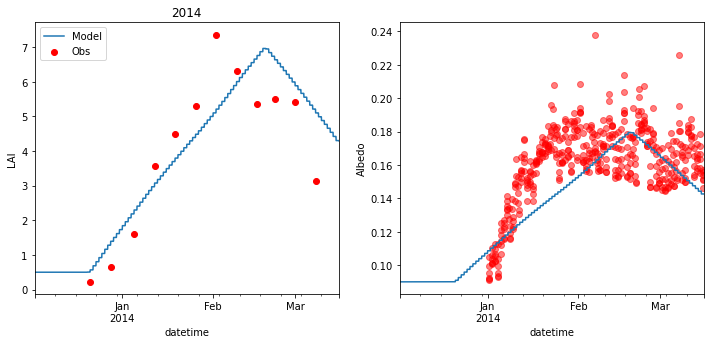

In [15]:
fig,axs=plt.subplots(1,2,figsize=(12,5))


ax=axs[0]
alb_model=df_output.SUEWS.loc[grid].resample('1h').mean().LAI.plot(ax=ax,label='Model')
ax.scatter(LAI_obs.index,LAI_obs,color='r',label='Obs')
ax.set_ylabel('LAI')
ax.legend()
ax.set_title(str(year))

ax=axs[1]
df_all=read_data(year)
df_sub=df_all.loc[p1:p2]
albedo=df_sub.Rg_out/df_sub.Rg
albedo=albedo[(albedo.index.hour>10)&(albedo.index.hour<14)]
albedo=albedo[albedo.between(0,1)]
alb_model=df_output.SUEWS.loc[grid].resample('1h').mean().AlbBulk
alb_model.plot(ax=ax)
ax.scatter(albedo.index,albedo,color='r',alpha=0.5)

ax.set_ylabel('Albedo')
plt.savefig('IRI-LAI_albedo'+str(year)+'.png',dpi=300,bbox_inches = 'tight',pad_inches = 0.01)

In [16]:
with open('albedo/'+name+'-IRI-'+str(year)+'-obs','wb') as f:
        pickle.dump(albedo, f)
with open('albedo/'+name+'-IRI-'+str(year)+'-Model','wb') as f:
        pickle.dump(alb_model, f)

# Evaporation test

In [17]:
# df_input_2013=to_SUEWS(2013)
# df_input_2014=to_SUEWS(2014)
# df_input=pd.concat([df_input_2013,df_input_2014])

# df_input.index=df_input.apply(lambda x: datetime.datetime(int(x.iy), 1, 1,int(x.it),int(x.imin)) + datetime.timedelta(int(x.id) - 1),
#                axis=1)
# df_input=df_input.replace(-999,np.nan)
# df_input=df_input.asfreq('300s').interpolate()
# df_input.iy=df_input.index.year
# df_input.it=df_input.index.hour
# df_input.imin=df_input.index.minute
# df_input['isec']=df_input.index.second
# df_input.id=df_input.id.astype(int)
# df_input.pres=df_input.pres*10
# df_input=df_input.rename(columns={'wuh':'Wuh'})
# df_input=df_input.replace(np.nan,-999)

In [18]:
from gs_util import IQR_compare,obs_sim


def irr_mod(df_state_init,df_forcing_run_2,year):
    df_state_init.loc[:,'surfacearea']=1
    df_state_init.loc[:,'waterusemethod']=1
    df_state_init.loc[:,'irrfracgrass']=1
    df_state_init.loc[:,'statelimit']=[0.48,0.25,1.3,0.8,   30  ,1.0,30000.0]
    df_state_init.loc[:,'wetthresh']=[0.48,0.25,1.3,0.8,   30  ,1.0,0.5]
    df_forcing_run_2.Wuh=0
    temp=df_forcing_run_2[df_forcing_run_2.index.hour>22]
    df_forcing_run_2.loc[temp.index,'Wuh']=(1*10000)*(3/100)
    if year==2013:
        df_forcing_run_2.loc[str(year)+' 10 7':,'Wuh']=0
    elif year ==2014:
        df_forcing_run_2.loc[str(year)+' 3 1':,'Wuh']=0
    return df_state_init,df_forcing_run_2



def modify_attr_2(df_state_init,g_max,s1):
    df_state_init.maxconductance=g_max
    df_state_init.s1=s1
    return df_state_init

def run_model_evap(tp,coef,lai_model,d1,d2,d3,g1,g2,g3,g4,g5,g6,g_max,s1,name,year,alpha=1):

    copyfile('runs/data/'+name+'_'+'all'+'_data_60.txt',
         "runs/run1/input/Kc_2012_data_60.txt")
    
    all_sites_info = pd.read_csv('site_info.csv')
    site_info = all_sites_info[all_sites_info['Site Id'] == name]
    df = pd.DataFrame({
        'Site': [name],
        'Latitude': [site_info['Latitude (degrees)']],
        'Longitude': [site_info['Longitude (degrees)']]
    })    
    
    path_runcontrol = Path('runs/run1'+'/') / 'RunControl.nml'
    df_state_init = sp.init_supy(path_runcontrol)
    grid = df_state_init.index[0]
    df_forcing_run = sp.load_forcing_grid(path_runcontrol, grid)
    df_forcing_run=df_forcing_run.rename(columns={'wuh':'Wuh'})
    df_state_init,df_forcing_run=irr_mod(df_state_init,df_forcing_run,year)
    
    a=df_state_init.loc[:,'ohm_coef'].values[0]
    
    for i in [0,1,2,3]:
        s=4
        a[(s)*4*3+((i)*3)+(0)]=coef[0]
        a[(s)*4*3+((i)*3)+(1)]=coef[1]
        a[(s)*4*3+((i)*3)+(2)]=coef[2]

    df_state_init.loc[:,'ohm_coef']=a
    
    
    df_forcing_run_2=df_forcing_run.loc[d1:d2]
    lai_sub=lai_model
    lai_sub.index=[x+datetime.timedelta(hours=12) for x in lai_sub.index]
    a=df_forcing_run_2.loc[lai_sub.index].dropna()
#     bb=lai_sub[lai_sub<3]
#     lai_sub.loc[bb.index]=7

    
    df_forcing_run_2.loc[a.index,'lai']=lai_sub.loc[a.index]
    
    df_forcing_run_2.loc[~df_forcing_run_2.index.isin(a.index),'lai']=np.nan
    df_forcing_run_2.lai=df_forcing_run_2.lai.interpolate(limit_direction='both')
    
    
    df_forcing_run_2.qn=sp.util.fill_gap_all(df_forcing_run_2.qn.replace(-999,np.nan))
    
    a=df_forcing_run_2[df_forcing_run_2.ldown<0]
    df_forcing_run_2.loc[a.index,'ldown']=-999
    df_forcing_run_2.ldown=sp.util.fill_gap_all(df_forcing_run_2.ldown.replace(-999,np.nan))

    df_state_init ,level= modify_attr(df_state_init, df, name)
    df_state_init.loc[:,'laicalcyes']=0
    mi=df_state_init.loc[:,'laimin'].values[0][2]
    ma=df_state_init.loc[:,'laimax'].values[0][2]
    df_state_init.loc[:,'laimin']=[mi,mi,mi]
    df_state_init.loc[:,'laimax']=[ma,ma,ma]    

    df_state_init.g1=g1*alpha
    df_state_init.g2=g2
    df_state_init.g3=g3
    df_state_init.g4=g4
    df_state_init.g5=g5
    df_state_init.g6=g6
    df_state_init.loc[:,'netradiationmethod']=0

    
    df_state_init=modify_attr_2(df_state_init,g_max,s1)
    
    if tp=='soil':
        df_forcing_run_2=df_forcing_run_2.loc[d1:d3]
        df_state_init.lai_id = 7
    else:
        df_forcing_run_2=df_forcing_run_2.loc[d3:d2]
    
    df_output, df_state_final = sp.run_supy(df_forcing_run_2, df_state_init, save_state=False)

    

    return df_output, df_state_init,df_forcing_run_2

In [23]:
year=2013
name='IRI'
if year==2014:
    p1=str(year-1)+' 12 02'
    p2=str(year)+' 03 15'
    p3=str(year)+' 01 5'
elif year==2013:
    
    p1=str(year)+' 06 27'
    p2=str(year)+' 10 21'
    p3=str(year)+' 08 01'
    #p2=str(year)+' 08 15'

    
tp='crop'

if tp=='soil':
    coef=[ 0.42,  0.102, -20.4]

    g_max=419.45872285126813
    s1=5.56
    alpha=0.34
    g1=0.367
    g2=104.713
    g3=0.192
    g4=0.568
    g5=36.46
    g6=0.049
else:

    coef=[ 0.49,  0.015, -15.4]

    with open('g1-g6/'+'cropr'+'-g','rb') as f:
        [g_max,alpha,g1,g2,g3,g4,g5,g6]=pickle.load(f)
    s1=5.56
    
    

lai_model=cal_LAI_model(year,p1,p2)
df_output, df_state_init,df_forcing_run_2=run_model_evap(tp,coef,lai_model,p1,p2,p3,
                                                         g1,g2,g3,g4,g5,g6,
                                                         g_max,s1,name,year,
                                                         alpha=alpha)


2020-04-15 13:33:26,113 — SuPy — INFO — All cache cleared.
2020-04-15 13:33:26,980 — SuPy — INFO — All cache cleared.


/Users/hamidrezaomidvar/anaconda3/envs/SUEWS_parameters/lib/python3.7/site-packages/numpy/lib/nanfunctions.py:1113: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis, out=out, keepdims=keepdims)


2020-04-15 13:33:31,987 — SuPy — INFO — ====================
2020-04-15 13:33:31,988 — SuPy — INFO — Simulation period:
2020-04-15 13:33:31,988 — SuPy — INFO —   Start: 2013-08-01 00:00:00
2020-04-15 13:33:31,989 — SuPy — INFO —   End: 2013-10-21 23:55:00
2020-04-15 13:33:31,990 — SuPy — INFO — 
2020-04-15 13:33:31,991 — SuPy — INFO — No. of grids: 1
2020-04-15 13:33:31,992 — SuPy — INFO — SuPy is running in serial mode
2020-04-15 13:33:39,936 — SuPy — INFO — Execution time: 7.9 s
2020-04-15 13:33:39,937 — SuPy — INFO — ====================



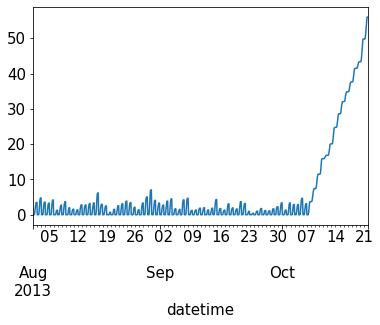

In [24]:
df_output.SUEWS.SMD.loc[grid,:].resample('1h').mean().plot()

/Users/hamidrezaomidvar/anaconda3/envs/SUEWS_parameters/lib/python3.7/site-packages/ipykernel_launcher.py:33: FutureWarning: 
Passing list-likes to .loc or [] with any missing label will raise
KeyError in the future, you can use .reindex() as an alternative.

See the documentation here:
https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#deprecate-loc-reindex-listlike
/Users/hamidrezaomidvar/anaconda3/envs/SUEWS_parameters/lib/python3.7/site-packages/ipykernel_launcher.py:45: FutureWarning: 
Passing list-likes to .loc or [] with any missing label will raise
KeyError in the future, you can use .reindex() as an alternative.

See the documentation here:
https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#deprecate-loc-reindex-listlike
/Users/hamidrezaomidvar/anaconda3/envs/SUEWS_parameters/lib/python3.7/site-packages/ipykernel_launcher.py:33: FutureWarning: 
Passing list-likes to .loc or [] with any missing label will raise
KeyError in the future, you c

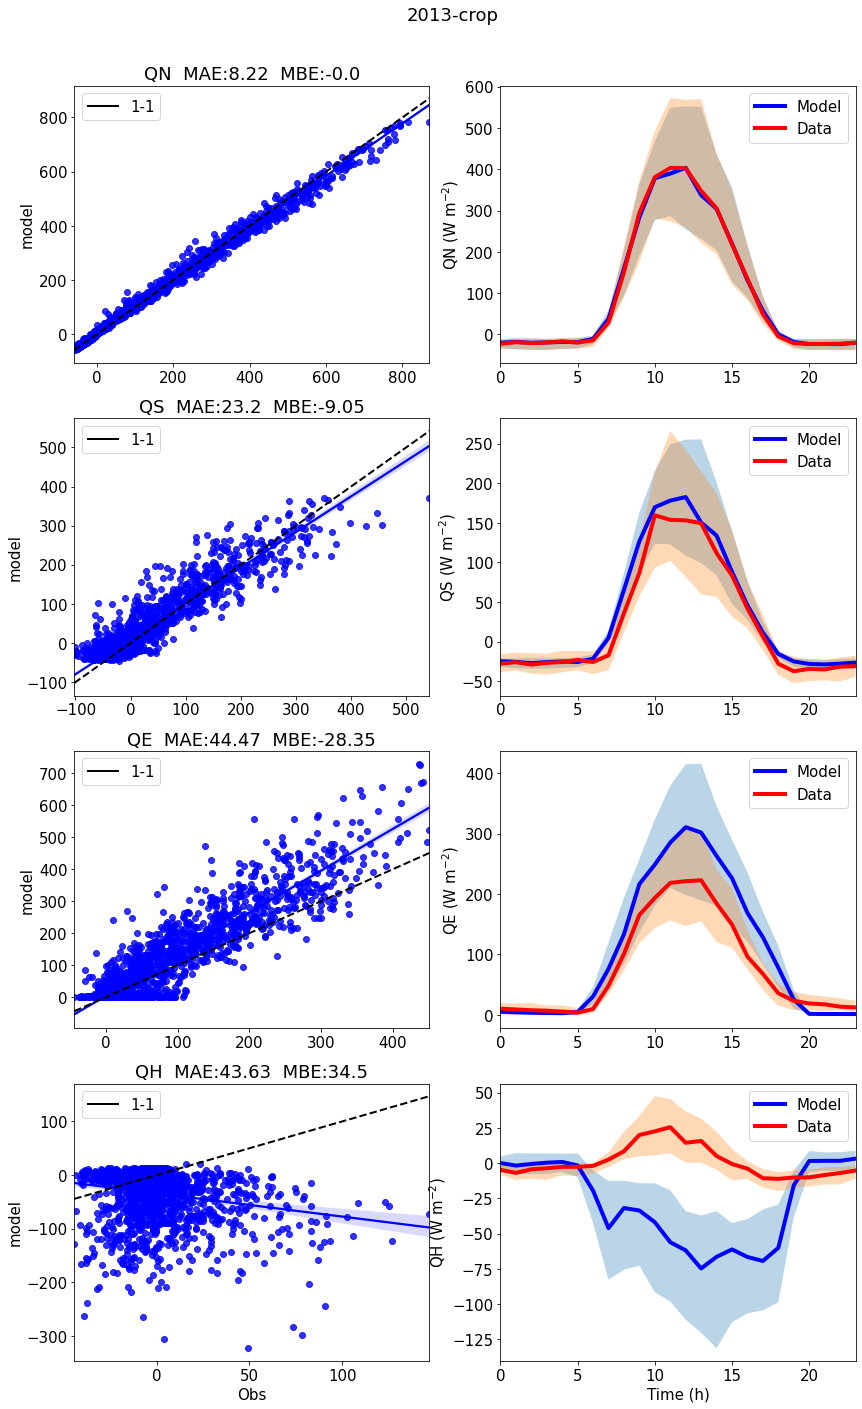

In [25]:
df_all= read_data_all().resample('1h').mean()
if tp=='soil':
    df_an=df_all.loc[p1:p3]
else:
    df_an=df_all.loc[p3:p2]
df_an.index=pd.to_datetime(df_an.index)
df_an=df_an

out=df_output.SUEWS.loc[grid]

out=out.resample('1h',closed='left',label='right').mean()

df_an['qs']=df_an.Rn-df_an.LE-df_an.H


var_meas=['Rn','qs','LE','H']
var_model=['QN','QS','QE','QH']

fig,axs=plt.subplots(len(var_meas),2,figsize=(14,22))
plt.rc('font', size=15)
fig.suptitle(str(year)+'-'+tp)
fig.subplots_adjust(top=0.93)

counter=-1
for varmeas,varmodel in zip(var_meas,var_model):
    counter=counter+1
    
    meas=df_an[varmeas].dropna()
    

    ax=axs[counter][0]
    temp=df_an.loc[meas.index]
    aa=out.loc[temp.index][varmodel].dropna()
    obs_sim(varmeas,varmodel,temp.loc[aa.index],out.loc[aa.index],ax)
    ax.set_ylabel('model')
    
    MAE=np.round(np.mean(abs(temp.loc[aa.index][varmeas]-out.loc[aa.index][varmodel])),2)
    MBE=np.round(np.mean((temp.loc[aa.index][varmeas]-out.loc[aa.index][varmodel])),2)

    if counter==len(var_model)-1:
        ax.set_xlabel('Obs')
    ax.set_title(varmodel+'  MAE:'+str(MAE)+'  MBE:'+str(MBE))
    
    ax=axs[counter][1]
    IQR_compare(varmeas,varmodel,temp,out.loc[temp.index],ax)
    ax.legend()
    if counter==len(var_model)-1:
        ax.set_xlabel('Time (h)')
    ax.set_ylabel(varmodel+' (W m$^{-2}$)')
# plt.savefig('IRI-SEB-'+tp+'-'+str(year)+'.png',dpi=300,bbox_inches = 'tight',pad_inches = 0.01)

In [26]:
all_data={}
all_data['model']=out.QE
all_data['obs']=df_an.LE
with open('surface_conductance/'+'cropr-phil-'+str(year),'wb') as f:
    pickle.dump(all_data, f)